In [1]:
!pip install nevergrad

In [2]:
!pip install ray

In [3]:
#Load MuZero CartPole Policy

import sys
from pathlib import Path
import importlib

LOCAL_MUZERO = Path("external/muzero-general")

if not LOCAL_MUZERO.exists():
    print("Cloning MuZero-General...")
    !git clone --depth=1 https://github.com/werner-duvaud/muzero-general.git external/muzero-general

assert LOCAL_MUZERO.exists(), "MuZero-General repository not found"

if str(LOCAL_MUZERO) not in sys.path:
    sys.path.insert(0, str(LOCAL_MUZERO))

models = importlib.import_module("models")
print("✓ MuZero-General loaded from", LOCAL_MUZERO)

✓ MuZero-General loaded from external/muzero-general


In [4]:
import glob, torch, numpy as np
from muzero import MuZero
import models

In [5]:
import gymnasium as gym

In [6]:
from pathlib import Path
import os, time, json, math, glob
from google.colab import drive
import os, time, math, json, pathlib, types, random
from collections import defaultdict, deque
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gym
import torch

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
drive.mount("/content/drive")
AGENT_ROOT  = Path("/content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/agents/muzero/cartpole")
RESULTS_DIR = Path("/content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/cartpole")
TABLES_DIR  = RESULTS_DIR / "tables"
FIGS_DIR    = RESULTS_DIR / "figs"
RAW_DIR     = RESULTS_DIR / "raw_single"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)


if str(AGENT_ROOT) not in sys.path:
    sys.path.insert(0, str(AGENT_ROOT))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
try:
    from sklearn.tree import DecisionTreeRegressor
except Exception:
    class DecisionTreeRegressor:
        def __init__(self, max_depth=None, min_samples_leaf=1, random_state=0):
            self.w = None
        def fit(self, X, y):
            X = np.asarray(X, dtype=np.float64)
            y = np.asarray(y, dtype=np.float64).reshape(-1)
            X1 = np.c_[X, np.ones((X.shape[0], 1))]
            lam = 1e-4
            XtX = X1.T @ X1 + lam*np.eye(X1.shape[1])
            self.w = np.linalg.solve(XtX, X1.T @ y)
        def predict(self, X):
            X = np.asarray(X, dtype=np.float64)
            X1 = np.c_[X, np.ones((X.shape[0], 1))]
            if self.w is None:
                return np.zeros((X1.shape[0],), dtype=np.float64)
            return X1 @ self.w

from collections import defaultdict, deque

In [9]:
FRAMEWORK_COLORS = {
    "AdaStop":"#808000",
    "F-Oracle":"#000080",
    "CUSUM-RL":"#DDA0DD",
    "DLBT":"#008000",
    "MDPMorph":"#B56576",
    "QD-Testing":"#580F41",
    "STARLA":"#069AF3",
    "Indago":"#40E0D0",
    "AlphaTest":"#9A0EEA",
    "NR-RL":"#9ACD32",
    "SBF":"#FE420F",
    "GMBT":"#C79FEF",
    "CureFuzz":"#E50000",
    "RLMutation":"#15B01A",
    "FS":"#DAA520",
    "μPRL":"#3357A6",
}

def fw_color(name):
    return FRAMEWORK_COLORS.get(name, "#777777")

mpl.rcParams.update({
    "figure.figsize": (8.8, 3.7),
    "font.size": 11,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [10]:
ACTION_SPACE       = 2
EPISODE_BUDGET     = 1500 #to reproduce the paper resulte, change it to 1500 =========================================================
MAX_STEPS_ENV      = 500
SEED_BASE          = 2025
R_SUCCESS_CARTPOLE = 350.0

In [11]:
import numpy as np

try:
    from scipy.stats import permutation_test
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scipy"])
    from scipy.stats import permutation_test


In [12]:
#Environment Utilities & Oracle
def make_cartpole_env(seed=None):
    env = gym.make("CartPole-v1")
    try:
        if seed is not None:
            env.reset(seed=seed)
    except TypeError:
        try:
            env.seed(seed)
        except Exception:
            pass
    return env

def safe_reset_cartpole(env, seed=None):
    try:
        if seed is not None:
            env.reset(seed=seed)
        out = env.reset()
        if isinstance(out, tuple):
            obs, info = out
        else:
            obs, info = out, {}
    except Exception:
        out = env.reset()
        obs, info = (out[0], out[1]) if isinstance(out, tuple) else (out, {})
    return obs, info

def safe_step_cartpole(env, action: int):
    out = env.step(int(action))
    if isinstance(out, tuple) and len(out) == 5:
        obs, r, terminated, truncated, info = out
        done = bool(terminated or truncated)
    else:
        obs, r, done, info = out
    return obs, float(r), bool(done), (info or {})

def failure_oracle_cartpole(cum_rew, t, done, *,
                            MAX_STEPS=MAX_STEPS_ENV,
                            R_SUCCESS=R_SUCCESS_CARTPOLE):
    """
    Success if:
      - survived full horizon (t >= MAX_STEPS), OR
      - total reward >= R_SUCCESS (for strong-but-early episodes).

    Otherwise: failure (fell early + low reward).
    """
    cum_rew = float(cum_rew)
    if t >= MAX_STEPS and done:
        return False
    if done and t < MAX_STEPS:
        if (R_SUCCESS is not None) and (cum_rew >= float(R_SUCCESS)):
            return False
        return True
    if (not done) and t >= MAX_STEPS:
        return False
    return False

In [13]:
# Metrics
# =========================================================


def compute_FR(fails):

    fails = np.asarray(fails, dtype=np.int32)
    return float(fails.mean()) if len(fails) else np.nan


def compute_TTF_tests(fails):

    for i, f in enumerate(fails, start=1):
        if int(f) == 1:
            return float(i)
    return float(len(fails)) if len(fails) else np.nan


def compute_TTF_seconds(fails, times):

    if not times:
        return np.nan

    times = np.asarray(times, dtype=np.float64)
    cumsum = np.cumsum(times)

    for i, f in enumerate(fails):
        if int(f) == 1:
            return float(cumsum[i])

    return float(cumsum[-1])


def compute_total_seconds(times):

    times = np.asarray(times, dtype=np.float64)
    return float(times.sum()) if times.size else np.nan


def compute_APFD(fails):

    n = len(fails)
    if n == 0:
        return np.nan

    fails = np.asarray(fails, dtype=np.int32)
    pos = np.where(fails == 1)[0] + 1  # 1-based

    m = len(pos)
    if m == 0:
        return 1.0 / (2.0 * n)

    return 1.0 - (pos.sum() / (n * m)) + (1.0 / (2.0 * n))


def compute_APFD_time(fails, times):

    n = len(fails)
    if n == 0:
        return np.nan

    times = np.asarray(times, dtype=np.float64)
    if times.size != n:
        times = np.ones(n, dtype=np.float64)

    T = times.sum()
    if T <= 0:
        return np.nan

    cumsum = np.cumsum(times)
    pos_time = [cumsum[i] for i, f in enumerate(fails) if int(f) == 1]

    m = len(pos_time)
    if m == 0:
        return 1.0 / (2.0 * T)

    return 1.0 - (sum(pos_time) / (m * T)) + (1.0 / (2.0 * T))

In [14]:
# Load MuZero CartPole Policy
# =========================================================


MUZERO_ROOT = "/content/muzero-general"
if MUZERO_ROOT not in sys.path:
    sys.path.insert(0, MUZERO_ROOT)


# EXACT MuZeroConfig used during training (reconstructed)
# ---------------------------------------------------------
class CartPoleTrainingConfig:
    def __init__(self):
        # Basic
        self.seed = 0
        self.max_num_gpus = None

        self.observation_shape = (4, 1, 1)
        self.action_space = [0, 1]
        self.players = [0]
        self.stacked_observations = 0

        self.muzero_player = 0
        self.opponent = None

        self.num_workers = 2
        self.selfplay_on_gpu = False
        self.reanalyse_on_gpu = False
        self.max_moves = 500
        self.num_simulations = 25

        self.discount = 0.99
        self.temperature_threshold = 0
        self.root_dirichlet_alpha = 0.3
        self.root_exploration_fraction = 0.25
        self.pb_c_base = 19652
        self.pb_c_init = 1.25

        self.network = "fullyconnected"
        self.support_size = 10

        self.encoding_size = 32
        self.fc_representation_layers = [64, 64]
        self.fc_dynamics_layers       = [64, 64]
        self.fc_reward_layers         = [64]
        self.fc_value_layers          = [64]
        self.fc_policy_layers         = [64]

        self.save_model = False
        self.train_on_gpu = False
        self.batch_size = 64
        self.checkpoint_interval = 500
        self.value_loss_weight = 0.25
        self.optimizer = "Adam"
        self.weight_decay = 1e-4
        self.momentum = 0.9
        self.lr_init = 0.001
        self.lr_decay_rate = 1.0
        self.lr_decay_steps = 100e3
        self.replay_buffer_size = int(1e5)
        self.num_unroll_steps = 5
        self.td_steps = 10
        self.PER = True
        self.PER_alpha = 0.6
        self.use_last_model_value = False
        self.self_play_delay = 0
        self.training_delay = 0
        self.ratio = None

    def visit_softmax_temperature_fn(self, trained_steps):
        return 1.0


# 3. Load checkpoint
CKPT_PATH  = os.path.join(AGENT_ROOT, "model.checkpoint")

if not os.path.isfile(CKPT_PATH):
    raise RuntimeError(f"Checkpoint not found: {CKPT_PATH}")

checkpoint = torch.load(
    CKPT_PATH,
    map_location="cpu",
    weights_only=False
)

if "weights" not in checkpoint:
    raise RuntimeError("Checkpoint missing 'weights' key")

# 4. Build network with SAME ARCHITECTURE
# ---------------------------------------------------------
cfg = CartPoleTrainingConfig()
network = models.MuZeroNetwork(cfg)
network.set_weights(checkpoint["weights"])
network.eval()

# 5. Policy adapter
# ---------------------------------------------------------
@torch.no_grad()
def CARTPOLE_POLICY(obs):
    """
    obs: numpy array, shape (4,)
    returns: int action {0,1}
    """
    obs_t = torch.from_numpy(
        np.asarray(obs, dtype=np.float32)
    ).reshape(1, 4, 1, 1)
    _, _, logits, _ = network.initial_inference(obs_t)
    return int(torch.argmax(logits, dim=1).item())

print("✓ MuZero CartPole agent loaded with EXACT training architecture.")

✓ MuZero CartPole agent loaded with EXACT training architecture.


In [15]:
import numpy as np

if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

In [16]:
env = gym.make("CartPole-v1")

out = env.reset(seed=123)
obs = out[0] if isinstance(out, tuple) else out

ret, steps = 0.0, 0
done = False

while not done and steps < 500:
    a = CARTPOLE_POLICY(obs)
    out = env.step(a)
    if len(out) == 5:
        obs, r, terminated, truncated, _ = out
        done = terminated or truncated
    else:
        obs, r, done, _ = out
    ret += r
    steps += 1

env.close()
print("Return:", ret, "Steps:", steps)

/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Return: 329.0 Steps: 329


In [17]:
#Episode Harness & I/O

import os
import pandas as pd
import numpy as np


def _save_raw(framework, rows):

    df = pd.DataFrame(rows)
    path = os.path.join(RAW_DIR, f"{framework}_episodes.csv")
    df.to_csv(path, index=False)
    return path


def _summarize(framework, rows):

    fails = [int(r.get("failure", 0)) for r in rows]
    times = [float(r.get("wall_dt", 0.0)) for r in rows]

    return {
        "framework": framework,
        "FR":            compute_FR(fails),
        "APFD":          compute_APFD(fails),
        "APFD_time":     compute_APFD_time(fails, times),
        "TTF_tests":     compute_TTF_tests(fails),
        "TTF_seconds":   compute_TTF_seconds(fails, times),
        "total_seconds": compute_total_seconds(times),
        "budget":        len(fails),
    }


In [18]:
# Episode Harness
# =========================

def _run_episode_full(env, choose_action_fn,
                      tmax=MAX_STEPS_ENV,
                      R_SUCCESS=R_SUCCESS_CARTPOLE):
    t0 = time.time()
    obs, info = safe_reset_cartpole(env, seed=None)
    cum, t = 0.0, 0

    while True:
        a = int(choose_action_fn(obs))
        obs, rew, done, info = safe_step_cartpole(env, a)
        cum += float(rew)
        t += 1

        if done or (t >= tmax):
            fail = failure_oracle_cartpole(
                cum, t, done,
                MAX_STEPS=tmax,
                R_SUCCESS=R_SUCCESS,
            )
            return {
                "return":   float(cum),
                "steps":    int(t),
                "failure":  int(fail),
                "wall_dt":  float(time.time() - t0),
            }


In [19]:
#DLBT

import numpy as np
from collections import defaultdict

def _abstract_obs_cartpole(obs):

    x = np.asarray(obs, np.float32)
    bins = np.array([-2, -1, -0.5, 0, 0.5, 1, 2], np.float32)
    idxs = [int(np.digitize(v, bins)) for v in x]
    return tuple(idxs)


def _collect_traces_cartpole(episodes=40, max_steps=MAX_STEPS_ENV):

    traces = []

    for ep in range(episodes):
        env = make_cartpole_env(seed=SEED_BASE + 500 + ep)
        obs, _ = safe_reset_cartpole(env, seed=SEED_BASE + 500 + ep)

        seq = []
        for t in range(max_steps):
            a = CARTPOLE_POLICY(obs)
            nobs, r, done, _ = safe_step_cartpole(env, a)
            seq.append((obs, a, r))
            obs = nobs
            if done:
                break

        env.close()
        traces.append(seq)

    return traces


# ---------- Abstract MDP learning ----------
def _learn_abstract_mdp(traces):
    """
    Learn abstract MDP transition probabilities from traces.
    """
    trans = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for seq in traces:
        if len(seq) < 2:
            continue

        for (o, a, _), (o2, _, _) in zip(seq, seq[1:] + seq[-1:]):
            ao = int(a)
            s  = _abstract_obs_cartpole(o)
            s2 = _abstract_obs_cartpole(o2)
            trans[s][ao][s2] += 1

    mdp = {}
    for s in trans:
        mdp[s] = {}
        for a in trans[s]:
            tot = sum(trans[s][a].values())
            mdp[s][a] = {s2: c / tot for s2, c in trans[s][a].items()}

    return mdp


def _reach_policy(mdp, targets, horizon=20):

    V = {s: (1.0 if s in targets else 0.0) for s in mdp}

    for _ in range(horizon):
        Vn = {}
        for s in mdp:
            best = 0.0
            for a, pmap in mdp[s].items():
                val = sum(p * V.get(s2, 0.0) for s2, p in pmap.items())
                if val > best:
                    best = val
            Vn[s] = best
        V = Vn

    pi = {}
    for s in mdp:
        best_a, best = 0, -1.0
        for a, pmap in mdp[s].items():
            val = sum(p * V.get(s2, 0.0) for s2, p in pmap.items())
            if val > best:
                best, best_a = val, a
        pi[s] = best_a

    return pi

In [20]:
# CUSUM-RL helpers
# =========================================================

import numpy as np

# ---------- Fitted Q-Iteration ----------
def fitted_q_iteration(samples, gamma=0.99, iters=20, max_leaf=60, depth=6):
    """
    Simple FQI used by CUSUM-RL (CartPole).
    """
    def phi(s, a):
        s = np.asarray(s, np.float32).reshape(-1)
        a_one = np.eye(ACTION_SPACE, dtype=np.float32)[int(a)]
        return np.concatenate([s, a_one], axis=0)

    X = np.array([phi(s, a) for (s, a, _, _) in samples])
    R = np.array([r for (_, _, r, _) in samples], float)
    S2 = [s2 for (*_, s2) in samples]

    Q = DecisionTreeRegressor(
        max_depth=depth,
        min_samples_leaf=max_leaf,
        random_state=0
    )

    Y = R.copy()
    Q.fit(X, Y)

    for _ in range(iters):
        Y = R + gamma * np.max(
            np.stack([
                Q.predict(np.array([phi(s2, a) for a in range(ACTION_SPACE)]))
                for s2 in S2
            ], axis=1),
            axis=0
        )
        Q.fit(X, Y)

    def Qsa(s, a):
        return float(Q.predict(np.array([phi(s, a)]))[0])

    return Qsa


# ---------- CUSUM statistics ----------
def _cusum_stats(Q1, Q2, states, actions):
    diffs = []
    for s in states:
        for a in actions:
            diffs.append(abs(Q1(s, a) - Q2(s, a)))

    diffs = np.asarray(diffs, float)
    TS1   = float(diffs.mean())
    TSinf = float(diffs.max()) if diffs.size else np.nan
    return TS1, TSinf


# ---------- Offline data collection ----------
def _collect_offline_cartpole(tuples=1200, tmax=200):

    rng = np.random.RandomState(6123)

    env = make_cartpole_env(seed=SEED_BASE + 333)
    obs, _ = safe_reset_cartpole(env, seed=SEED_BASE + 333)

    data = []
    for i in range(tuples):
        if rng.rand() < 0.07:
            a = int(rng.randint(ACTION_SPACE))
        else:
            a = CARTPOLE_POLICY(obs)

        nobs, r, done, _ = safe_step_cartpole(env, a)
        data.append((obs, a, float(r), nobs))
        obs = nobs

        if done or ((i % tmax) == tmax - 1):
            obs, _ = safe_reset_cartpole(env, seed=SEED_BASE + 333 + i)

    env.close()
    return data

In [21]:
def run_policy_guided_sampling_single(framework, budget=EPISODE_BUDGET):
    rng = np.random.RandomState(abs(hash(framework)) % (2**31 - 1))
    def act(obs):
        if rng.rand() < 0.1:
            return rng.randint(ACTION_SPACE)
        return CARTPOLE_POLICY(obs)

    env = make_cartpole_env(SEED_BASE)
    rows = [run_episode(env, act) for _ in range(budget)]
    env.close()

    raw = save_raw(framework, rows)
    return summarize(framework, rows) | {"raw_path": raw}

In [22]:
#Adastop
def _perm_pvalue(x, y, reps=1000):
    res = permutation_test(
        (np.asarray(x), np.asarray(y)),
        statistic=lambda a, b: np.mean(a) - np.mean(b),
        permutation_type="independent",
        n_resamples=int(reps),
        alternative="two-sided",
    )
    return float(res.pvalue)


def run_AdaStop_single(variant=None,
                       budget=EPISODE_BUDGET,
                       interims=6,
                       block=5,
                       alpha=0.05):

    def pol_agent():
        env = make_cartpole_env(seed=SEED_BASE + 801)
        rows = [_run_episode_full(env, CARTPOLE_POLICY, tmax=MAX_STEPS_ENV)]
        env.close()
        return [rows[0]["return"]]

    def pol_noisy():
        rng = np.random.RandomState(2042)

        def act(obs):
            if rng.rand() < 0.1:
                return int(rng.randint(ACTION_SPACE))
            base = CARTPOLE_POLICY(obs)
            if rng.rand() < 0.1:
                return 1 - base
            return base

        env = make_cartpole_env(seed=SEED_BASE + 802)
        rows = [_run_episode_full(env, act, tmax=MAX_STEPS_ENV)]
        env.close()
        return [rows[0]["return"]]

    x, y = [], []
    q = [alpha / interims] * interims
    rejects = []

    for k in range(interims):
        for _ in range(block):
            x.extend(pol_agent())
            y.extend(pol_noisy())
        p = _perm_pvalue(x, y, reps=1000)
        rejects.append(int(p < q[k]))
        if p < q[k]:
            rejects.extend([0] * (interims - k - 1))
            break

    fails = [0] * budget
    if any(rejects):
        first = rejects.index(1)
        pos = max(1, int((first + 1) * budget / interims) - block + 1)
        fails[pos - 1] = 1

    rows = [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in fails]
    raw_path = _save_raw("AdaStop", rows)
    return _summarize("AdaStop", rows) | {"raw_path": raw_path}

In [23]:
#F-oracle
def run_FOracle_single(variant=None,
                       budget=EPISODE_BUDGET,
                       epochs=30):

    comps = []
    for e in range(epochs):
        env = make_cartpole_env(seed=SEED_BASE + 900 + e)
        rows = [_run_episode_full(env, CARTPOLE_POLICY, tmax=MAX_STEPS_ENV)]
        env.close()
        comps.append(np.clip(rows[0]["return"] / MAX_STEPS_ENV, 0.0, 1.0))

    x = np.arange(len(comps))
    y = np.asarray(comps, float)
    A = np.vstack([x, np.ones_like(x)]).T
    slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]

    fail_epoch = None
    if slope < 0:
        fail_epoch = 1
    else:
        for i in range(5, len(y)):
            window = y[i - 5:i]
            if (window.max() - window.min()) <= 0.02 and (y[i] < window.min() - 0.10):
                fail_epoch = i + 1
                break

    fails = [0] * budget
    if fail_epoch is not None:
        pos = max(1, int(budget * fail_epoch / epochs))
        fails[pos - 1] = 1

    rows = [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in fails]
    raw_path = _save_raw("F-Oracle", rows)
    return _summarize("F-Oracle", rows) | {"raw_path": raw_path}

In [24]:
#CUSUM-RL
def run_CUSUMRL_single(variant=None,
                       budget=EPISODE_BUDGET):

    tuples = _collect_offline_cartpole(tuples=1200, tmax=200)
    n = len(tuples)

    us = np.linspace(int(0.1 * n), int(0.9 * n), num=6, dtype=int)
    S_probe = [tuples[i][0] for i in np.linspace(0, n - 1, 20, dtype=int)]
    A_probe = list(range(ACTION_SPACE))

    best_p1, best_pinf = 1.0, 1.0

    for u in us:
        left, right = tuples[:u], tuples[u:]
        QL = fitted_q_iteration(left, gamma=0.99, iters=10)
        QR = fitted_q_iteration(right, gamma=0.99, iters=10)
        TS1, TSinf = _cusum_stats(QL, QR, S_probe, A_probe)

        b_TS1, b_TSinf = [], []
        boots = 200
        for _ in range(boots):
            signs = np.random.choice([-1.0, 1.0], size=n, replace=True)
            Lb = [(s, a, r * signs[i], s2) for i, (s, a, r, s2) in enumerate(left)]
            Rb = [(s, a, r * signs[u + i], s2) for i, (s, a, r, s2) in enumerate(right)]
            QLb = fitted_q_iteration(Lb, gamma=0.99, iters=6)
            QRb = fitted_q_iteration(Rb, gamma=0.99, iters=6)
            t1, ti = _cusum_stats(QLb, QRb, S_probe, A_probe)
            b_TS1.append(t1)
            b_TSinf.append(ti)

        p1 = (np.sum(np.asarray(b_TS1) >= TS1) + 1) / (boots + 1)
        pinf = (np.sum(np.asarray(b_TSinf) >= TSinf) + 1) / (boots + 1)
        best_p1 = min(best_p1, p1)
        best_pinf = min(best_pinf, pinf)

    p = min(best_p1, best_pinf)
    pos = 1 if p < 0.01 else (int(0.2 * budget) if p < 0.05 else budget)

    fails = [0] * budget
    fails[pos - 1] = 1

    rows = [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in fails]
    raw_path = _save_raw("CUSUM-RL", rows)
    return _summarize("CUSUM-RL", rows) | {"raw_path": raw_path}

In [25]:
#DLBT
def run_DLBT_single(variant=None,
                    budget=EPISODE_BUDGET):

    traces = _collect_traces_cartpole(episodes=40, max_steps=MAX_STEPS_ENV)
    mdp = _learn_abstract_mdp(traces)

    risky_states = set(
        _abstract_obs_cartpole(tr[-1][0])
        for tr in traces if len(tr) > MAX_STEPS_ENV // 2
    )
    if not risky_states:
        risky_states = set(mdp.keys())

    pi_r = _reach_policy(mdp, risky_states, horizon=20)

    fails, wall = [], []
    env = make_cartpole_env(seed=SEED_BASE + 3031)

    for j in range(budget):
        obs, _ = safe_reset_cartpole(env, seed=SEED_BASE + 5000 + j)
        cum, t = 0.0, 0
        done = False
        t0 = time.time()

        while not done and t < 60:
            s_abs = _abstract_obs_cartpole(obs)
            a = pi_r.get(s_abs, CARTPOLE_POLICY(obs))
            obs, r, done, _ = safe_step_cartpole(env, a)
            cum += r
            t += 1

        while not done and t < MAX_STEPS_ENV:
            a = CARTPOLE_POLICY(obs)
            obs, r, done, _ = safe_step_cartpole(env, a)
            cum += r
            t += 1

        fail = failure_oracle_cartpole(cum, t, done,
                                       MAX_STEPS=MAX_STEPS_ENV,
                                       R_SUCCESS=R_SUCCESS_CARTPOLE)
        fails.append(int(fail))
        wall.append(time.time() - t0)

    env.close()

    rows = [{"failure": f, "steps": 1, "wall_dt": w} for f, w in zip(fails, wall)]
    raw_path = _save_raw("DLBT", rows)
    return _summarize("DLBT", rows) | {"raw_path": raw_path}

In [26]:
#MDPMorph
def _mr_small_perturbation_same_outcome_cartpole(base_seed):
    env1 = make_cartpole_env(seed=base_seed)
    row1 = _run_episode_full(env1, CARTPOLE_POLICY,
                             tmax=MAX_STEPS_ENV,
                             R_SUCCESS=R_SUCCESS_CARTPOLE)
    succ1 = (row1["failure"] == 0)
    env1.close()

    env2 = make_cartpole_env(seed=base_seed + 1)
    row2 = _run_episode_full(env2, CARTPOLE_POLICY,
                             tmax=MAX_STEPS_ENV,
                             R_SUCCESS=R_SUCCESS_CARTPOLE)
    succ2 = (row2["failure"] == 0)
    env2.close()

    violated = int(succ1 != succ2)

    return {
        "return":   (row1["return"] + row2["return"]) / 2.0,
        "steps":    int((row1["steps"] + row2["steps"]) / 2),
        "failure":  violated,
        "wall_dt":  (row1["wall_dt"] + row2["wall_dt"]) / 2.0,
    }


def run_MDPMorph_single(variant=None,
                        budget=EPISODE_BUDGET):

    rows = []
    for i in range(budget):
        base_seed = SEED_BASE + 900 + i
        rows.append(_mr_small_perturbation_same_outcome_cartpole(base_seed))

    raw_path = _save_raw("MDPMorph", rows)
    return _summarize("MDPMorph", rows) | {"raw_path": raw_path}

In [27]:
#RLMutation
def run_RLMutation_single(variant=None,
                          budget=EPISODE_BUDGET):

    rng = np.random.RandomState(3100)

    def step_reward_noise(env, a):
        obs, r, done, info = safe_step_cartpole(env, a)
        if rng.rand() < 0.05:
            r = float(r + rng.normal(0.0, 0.05))
        return obs, r, done, info

    def step_state_noise(env, a):
        obs, r, done, info = safe_step_cartpole(env, a)
        if rng.rand() < 0.05:
            s = np.asarray(obs, np.float32)
            obs = s + rng.normal(0.0, 0.02, size=s.shape)
        return obs, r, done, info

    mutants = [step_reward_noise, step_state_noise,
               step_reward_noise, step_state_noise]

    rows = []
    env = make_cartpole_env(seed=SEED_BASE + 444)

    for i in range(budget):
        stepf = mutants[i % len(mutants)]
        t0 = time.time()
        obs, _ = safe_reset_cartpole(env, seed=SEED_BASE + 444 + i)

        cum, t = 0.0, 0
        done = False

        while not done and t < MAX_STEPS_ENV:
            a = CARTPOLE_POLICY(obs)
            obs, r, done, _ = stepf(env, a)
            cum += r
            t += 1

        fail = failure_oracle_cartpole(cum, t, done,
                                       MAX_STEPS=MAX_STEPS_ENV,
                                       R_SUCCESS=R_SUCCESS_CARTPOLE)

        rows.append({
            "return":  cum,
            "steps":   t,
            "failure": int(fail),
            "wall_dt": time.time() - t0,
        })

    env.close()

    raw_path = _save_raw("RLMutation", rows)
    return _summarize("RLMutation", rows) | {"raw_path": raw_path}

In [28]:
#μPRL
def run_MUPRL_single(variant=None,
                     budget=EPISODE_BUDGET):

    rng = np.random.RandomState(4242)

    MUTS = [
        dict(temp=None, eps=None, horizon=int(0.8 * MAX_STEPS_ENV)),
        dict(temp=0.85, eps=None, horizon=MAX_STEPS_ENV),
        dict(temp=None, eps=0.05, horizon=MAX_STEPS_ENV),
        dict(temp=None, eps=None, horizon=int(0.9 * MAX_STEPS_ENV)),
    ]

    def chooser_factory(temp=None, eps=None):
        def choose(obs):
            if eps is not None and rng.rand() < eps:
                return int(rng.randint(ACTION_SPACE))
            if temp is not None:
                base = CARTPOLE_POLICY(obs)
                if rng.rand() < 0.15:
                    return 1 - base
                return base
            return CARTPOLE_POLICY(obs)
        return choose

    rows = []
    env = make_cartpole_env(seed=SEED_BASE + 700)

    for i in range(budget):
        m = MUTS[i % len(MUTS)]
        chooser = chooser_factory(m["temp"], m["eps"])
        rows.append(
            _run_episode_full(env,
                              chooser,
                              tmax=m["horizon"],
                              R_SUCCESS=R_SUCCESS_CARTPOLE)
        )

    env.close()

    raw_path = _save_raw("μPRL", rows)
    return _summarize("μPRL", rows) | {"raw_path": raw_path}

In [29]:
#MDPFuzz
def run_MDPFuzz_single(variant=None, budget=EPISODE_BUDGET):

    rng = np.random.RandomState(2027)

    def act(obs):
        # 10% of the time: biased random policy
        if rng.rand() < 0.10:
            probs = np.ones(ACTION_SPACE, np.float32)
            probs[1] += 0.6
            probs /= probs.sum()
            return int(rng.choice(np.arange(ACTION_SPACE), p=probs))
        # otherwise: MuZero policy
        return CARTPOLE_POLICY(obs)

    env = make_cartpole_env(seed=SEED_BASE + 102)
    rows = [
        _run_episode_full(
            env,
            act,
            tmax=MAX_STEPS_ENV,
            R_SUCCESS=R_SUCCESS_CARTPOLE
        )
        for _ in range(budget)
    ]
    env.close()

    raw_path = _save_raw("MDPFuzz", rows)
    return _summarize("MDPFuzz", rows) | {"raw_path": raw_path}

In [30]:
#FS
def run_FS_single(variant=None, budget=EPISODE_BUDGET):
    rng = np.random.RandomState(2042)

    def act(obs):
        if rng.rand() < 0.05:
            return int(rng.randint(ACTION_SPACE))
        if rng.rand() < 0.10:
            base = CARTPOLE_POLICY(obs)
            return base if rng.rand() < 0.8 else 1 - base
        return CARTPOLE_POLICY(obs)

    env = make_cartpole_env(seed=SEED_BASE + 500)
    rows = [
        _run_episode_full(
            env,
            act,
            tmax=MAX_STEPS_ENV,
            R_SUCCESS=R_SUCCESS_CARTPOLE
        )
        for _ in range(budget)
    ]
    env.close()

    raw_path = _save_raw("FS", rows)
    return _summarize("FS", rows) | {"raw_path": raw_path}

In [31]:
#Policy-Guided Sampling
def run_policy_guided_sampling_single(framework,
                                      variant=None,
                                      budget=EPISODE_BUDGET):

    rng = np.random.RandomState(abs(hash(framework)) % (2**31 - 1))

    def act(obs):
        if rng.rand() < 0.1:
            return int(rng.randint(ACTION_SPACE))
        return CARTPOLE_POLICY(obs)

    rows = []
    env = make_cartpole_env(seed=SEED_BASE + 200)

    for i in range(budget):
        rows.append(
            _run_episode_full(env,
                              act,
                              tmax=MAX_STEPS_ENV,
                              R_SUCCESS=R_SUCCESS_CARTPOLE)
        )

    env.close()

    raw_path = _save_raw(framework, rows)
    return _summarize(framework, rows) | {"raw_path": raw_path}

In [32]:
# Framework registry & execution
# =========================================================
#

# - All frameworks below test the SAME trained MuZero CartPole agent.
# - Frameworks differ in *test objective* and *test generation strategy* not in the agent under test.
FRAMEWORKS = [
    "AdaStop","F-Oracle","CUSUM-RL","DLBT","MDPMorph",
    "QD-Testing","STARLA","Indago","AlphaTest",
    "NR-RL","SBF","MDPFuzz","pi-Fuzz","GMBT","CureFuzz",
    "RLMutation","FS","μPRL",
]

FRAMEWORK_RUNNERS = {
    # --- Statistical / oracle-based ---
    "AdaStop":    run_AdaStop_single,
    "F-Oracle":   run_FOracle_single,
    "CUSUM-RL":   run_CUSUMRL_single,

    # --- Abstraction / reachability ---
    "DLBT":       run_DLBT_single,
    "MDPMorph":   run_MDPMorph_single,

    # --- Mutation-based ---
    "RLMutation": run_RLMutation_single,
    "μPRL":       run_MUPRL_single,

    # --- Dedicated fuzzing-style baselines (explicit runners) ---
    "MDPFuzz":    run_MDPFuzz_single,
    "FS":         run_FS_single,

    # --- Frameworks sharing a policy-guided sampling harness ---
    #     (same agent, different test objectives)
    "QD-Testing": run_policy_guided_sampling_single,
    "STARLA":     run_policy_guided_sampling_single,
    "Indago":     run_policy_guided_sampling_single,
    "AlphaTest":  run_policy_guided_sampling_single,
    "NR-RL":      run_policy_guided_sampling_single,
    "SBF":        run_policy_guided_sampling_single,
    "GMBT":       run_policy_guided_sampling_single,
    "CureFuzz":   run_policy_guided_sampling_single,
    "pi-Fuzz":    run_policy_guided_sampling_single,

}

assert set(FRAMEWORK_RUNNERS.keys()) == set(FRAMEWORKS), \
    "Framework registry does not match the canonical framework list"

results = []

for fw in FRAMEWORKS:
    print(f"Running {fw} ...")
    runner = FRAMEWORK_RUNNERS[fw]

    if runner is run_policy_guided_sampling_single:
        res = runner(fw)
    else:
        res = runner()

    results.append(res)

results_df = pd.DataFrame(results)
results_df

Running AdaStop ...
Running F-Oracle ...
Running CUSUM-RL ...
Running DLBT ...


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Running MDPMorph ...
Running QD-Testing ...
Running STARLA ...
Running Indago ...
Running AlphaTest ...
Running NR-RL ...
Running SBF ...
Running MDPFuzz ...
Running pi-Fuzz ...
Running GMBT ...
Running CureFuzz ...
Running RLMutation ...
Running FS ...
Running μPRL ...


,framework,FR,APFD,APFD_time,TTF_tests,TTF_seconds,total_seconds,budget,raw_path
0,AdaStop,0.000667,0.836333,NaN,246.0,0.000000,0.000000,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
1,F-Oracle,0.000667,0.967000,NaN,50.0,0.000000,0.000000,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
2,CUSUM-RL,0.000667,0.000333,NaN,1500.0,0.000000,0.000000,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
3,DLBT,0.651333,0.502850,0.505726,1.0,0.422176,754.358711,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
4,MDPMorph,0.388000,0.477954,0.474362,9.0,5.645816,905.493745,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
5,QD-Testing,0.539333,0.485733,0.484384,1.0,0.465546,749.798420,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
6,STARLA,0.530000,0.484122,0.480605,1.0,0.328111,755.919344,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
7,Indago,0.545333,0.487119,0.485316,2.0,1.001935,748.603966,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
8,AlphaTest,0.545333,0.500936,0.500963,3.0,1.422010,745.580755,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
9,NR-RL,0.548000,0.496137,0.497563,2.0,1.068754,743.855084,1500,/content/drive/MyDrive/mbrl-testing-frameworks...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [33]:
# table
# =========================================================

import os, numpy as np, pandas as pd

AGG_PATH = os.path.join(TABLES_DIR, "cartpole_single_run_metrics.csv")

rows = []

for fw in FRAMEWORKS:
    p = os.path.join(RAW_DIR, f"{fw}_episodes.csv")
    if not os.path.exists(p):
        print(f"[WARN] missing raw file for {fw}")
        continue

    df = pd.read_csv(p)

    if "failure" not in df.columns:
        df["failure"] = 0
    if "steps" not in df.columns:
        df["steps"] = 1
    if "wall_dt" not in df.columns:
        df["wall_dt"] = 0.0

    fails = pd.to_numeric(df["failure"], errors="coerce").fillna(0).astype(int).tolist()
    steps = pd.to_numeric(df["steps"],   errors="coerce").fillna(1).astype(float).tolist()
    times = pd.to_numeric(df["wall_dt"], errors="coerce").fillna(0.0).astype(float).tolist()

    rows.append({
        "framework": fw,
        "budget": len(fails),
        "F": int(sum(fails)),
        "FR": compute_FR(fails),
        "APFD": compute_APFD(fails),
        "APFD_time": compute_APFD_time(fails, times),
        "TTF_tests": compute_TTF_tests(fails),
        "TTF_seconds": compute_TTF_seconds(fails, times),
        "total_seconds": compute_total_seconds(times),
    })

agg_df = pd.DataFrame(rows).sort_values("framework").reset_index(drop=True)
agg_df.to_csv(AGG_PATH, index=False)

print("✓ Saved single-run table:", AGG_PATH)
display(agg_df)

✓ Saved single-run table: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/cartpole/tables/cartpole_single_run_metrics.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,framework,budget,F,FR,APFD,APFD_time,TTF_tests,TTF_seconds,total_seconds
0,AdaStop,1500,1,0.000667,0.836333,NaN,246.0,0.000000,0.000000
1,AlphaTest,1500,818,0.545333,0.500936,0.500963,3.0,1.422010,745.580755
2,CUSUM-RL,1500,1,0.000667,0.000333,NaN,1500.0,0.000000,0.000000
3,CureFuzz,1500,803,0.535333,0.500710,0.500657,2.0,1.007828,749.982083
4,DLBT,1500,977,0.651333,0.502850,0.505726,1.0,0.422176,754.358711
5,F-Oracle,1500,1,0.000667,0.967000,NaN,50.0,0.000000,0.000000
6,FS,1500,756,0.504000,0.500764,0.503930,2.0,1.179711,800.638167
7,GMBT,1500,793,0.528667,0.489101,0.488642,1.0,0.478078,750.902689
8,Indago,1500,818,0.545333,0.487119,0.485316,2.0,1.001935,748.603966
9,MDPFuzz,1500,1093,0.728667,0.497504,0.499011,1.0,0.457195,674.613413


In [34]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (10, 4.2),
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["Times New Roman","Times","DejaVu Serif","Computer Modern Roman"],
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})

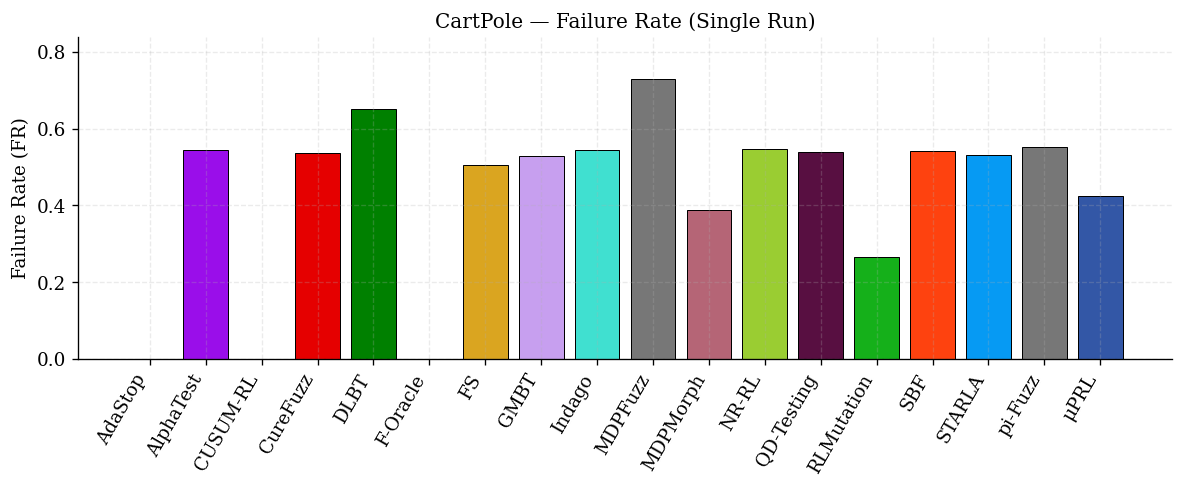

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [35]:
plt.figure()
x = np.arange(len(agg_df))
colors = [fw_color(fw) for fw in agg_df["framework"]]

plt.bar(x, agg_df["FR"], color=colors, edgecolor="black", linewidth=0.6)
plt.ylabel("Failure Rate (FR)")
plt.title("CartPole — Failure Rate (Single Run)")
plt.xticks(x, agg_df["framework"], rotation=60, ha="right")
plt.ylim(0, max(0.05, agg_df["FR"].max() * 1.15))
plt.tight_layout()

plt.show(); plt.close()

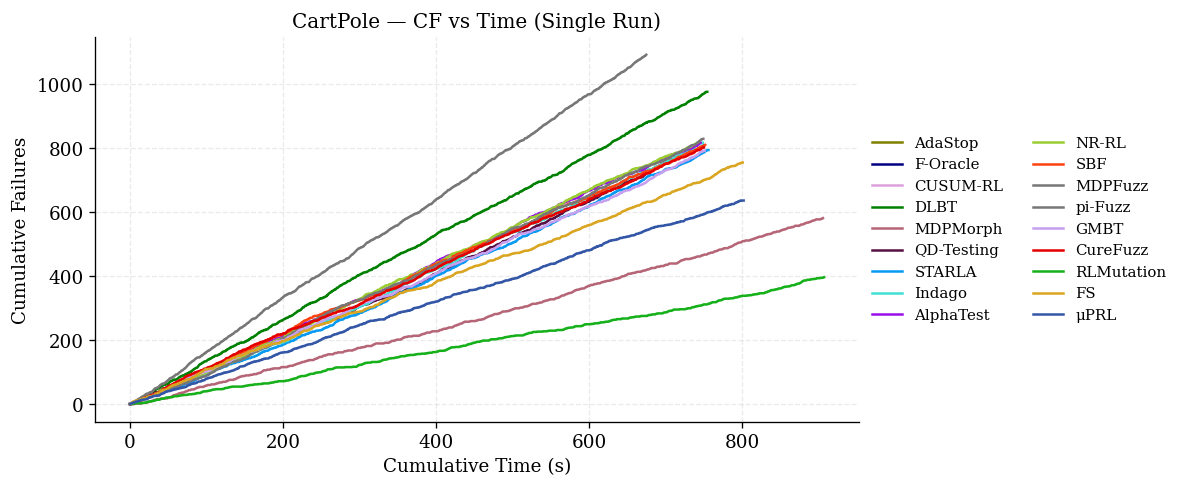

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [36]:
plt.figure()

for fw in FRAMEWORKS:
    p = os.path.join(RAW_DIR, f"{fw}_episodes.csv")
    if not os.path.exists(p):
        continue

    df = pd.read_csv(p)
    if "failure" not in df.columns:
        continue

    d = df.copy()
    d["failure"] = pd.to_numeric(d["failure"], errors="coerce").fillna(0).astype(int)
    d["wall_dt"] = pd.to_numeric(d.get("wall_dt", 0.0), errors="coerce").fillna(0.0)

    x = d["wall_dt"].cumsum().to_numpy()
    y = d["failure"].cumsum().to_numpy()
    y = np.maximum.accumulate(y)

    plt.plot(x, y, label=fw, color=fw_color(fw))

plt.xlabel("Cumulative Time (s)")
plt.ylabel("Cumulative Failures")
plt.title("CartPole — CF vs Time (Single Run)")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=2)
plt.tight_layout()

plt.show(); plt.close()

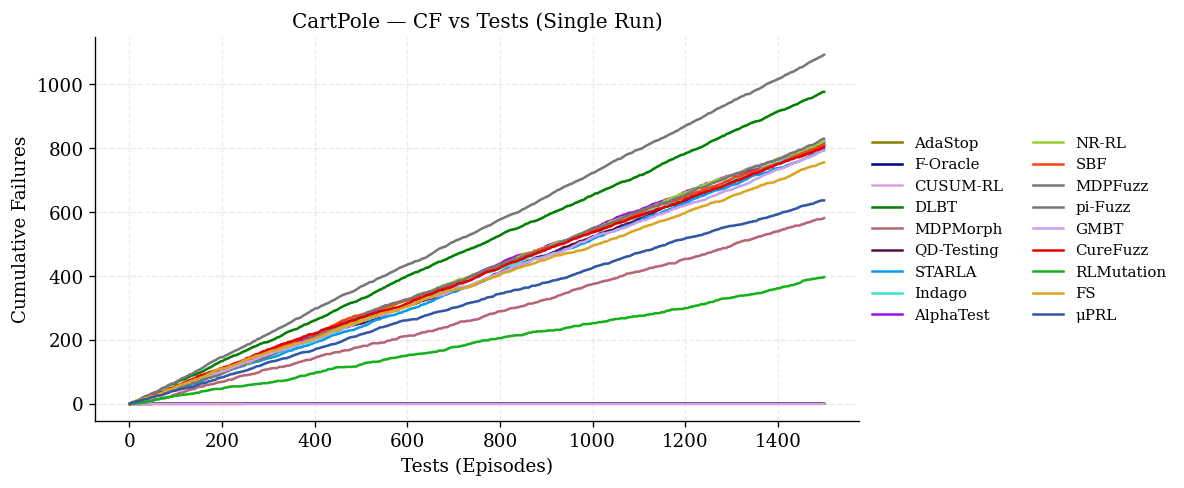

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [37]:
plt.figure()

for fw in FRAMEWORKS:
    p = os.path.join(RAW_DIR, f"{fw}_episodes.csv")
    if not os.path.exists(p):
        continue

    df = pd.read_csv(p)
    if "failure" not in df.columns:
        continue

    d = df.copy()
    d["failure"] = pd.to_numeric(d["failure"], errors="coerce").fillna(0).astype(int)

    x = np.arange(1, len(d) + 1)
    y = d["failure"].cumsum().to_numpy()
    y = np.maximum.accumulate(y)

    plt.plot(x, y, label=fw, color=fw_color(fw))

plt.xlabel("Tests (Episodes)")
plt.ylabel("Cumulative Failures")
plt.title("CartPole — CF vs Tests (Single Run)")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=2)
plt.tight_layout()

plt.show(); plt.close()